# Analysis of genes which are specific to ASD and CHD 

Test for enrichment of ASD and CHD (no NDD) dDNVs- for supplemental figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

import sys

import adjustText

% matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# Load ASD, CHD genesets

ASD HC genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [3]:
# ------- ASD high confidence genes (established disease genes) -------

HC_genes_temp = pd.read_csv('data/HC_genes/ASD_HC.tsv',sep='\t',index_col='Unnamed: 0')
ASD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

len(ASD_HC)


65

In [4]:
# ------- High confidence CHD genes (established disease genes) -------

# Load congenital heart defect recurring DNVs (from https://www.nature.com/articles/ng.3970)

HC_genes_temp = pd.read_csv('data/HC_genes/CHD_HC.tsv',sep='\t',index_col='Unnamed: 0')
CHD_HC = [str(g[1:-1]).strip("'") for g in HC_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]

len(CHD_HC)

66

In [5]:
# Load all CHD DNVs (from 2017 paper)

CHD_DNV_df = pd.read_excel('data/CHD_databases_2017_paper/ng.3970-S3.xlsx',sheetname='S9',skiprows=1)
CHD_DNV_df.index=CHD_DNV_df['Blinded ID']

# exclude patients which have variants in HC genes -- from Trey's comment April 2019
print(len(CHD_DNV_df))
CHD_DNV_df = CHD_DNV_df[~CHD_DNV_df['Gene'].isin(ASD_HC+CHD_HC)]
print(len(CHD_DNV_df))

# apply the same filtering as for old data
CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant_Class']!='syn')*(CHD_DNV_df['Variant_Class']!='mis')]
print('number damaging CHD DNVs:')
print(len(CHD_DNV))

CHD_DNV_VC = CHD_DNV['Gene'].value_counts() # count recurrences-- should be 0 because we removed them
print('\nnumber recurrent damaging CHD DNVs:')
print(sum(CHD_DNV_VC>1))

print('\nall unique CHD DNV genes')
CHD_DNV_all = CHD_DNV['Gene'].unique().tolist()
print(len(CHD_DNV_all))

DNV_withNDD_full = CHD_DNV[CHD_DNV['NDD']=='Yes']
print('\nnumber damaging CHD DNVs with NDD:')
print(len(DNV_withNDD_full)) # number of patients
DNV_withNDD_full = DNV_withNDD_full['Gene'].unique().tolist()
print('\nnumber damaging unique CHD DNVs with NDD:')
print(len(DNV_withNDD_full)) # number of genes

DNV_noNDD_full = CHD_DNV[CHD_DNV['NDD']=='No']
DNV_noNDD_full = DNV_noNDD_full['Gene'].unique().tolist()
print('\nnumber damaging CHD DNVs without NDD:')
print(len(DNV_noNDD_full))


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


2990
2760
number damaging CHD DNVs:
629

number recurrent damaging CHD DNVs:
0

all unique CHD DNV genes
629

number damaging CHD DNVs with NDD:
155

number damaging unique CHD DNVs with NDD:
155

number damaging CHD DNVs without NDD:
270


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Use all SSC patients, most will not have heart phenos

No heart phenos available

In [6]:
# load the SSC data DNV data (homsy et al S08)
SSC_DNV = pd.read_excel('data/SSC/homsy_database_S08.xlsx',
                       skiprows=1)

# Variant classes have already been filtered to be damaging

# filter by study == SSC
print(len(SSC_DNV))
SSC_DNV = SSC_DNV[SSC_DNV['Study']=='SSC']
print(len(SSC_DNV))
SSC_DNV.index=SSC_DNV['Proband ID']




1563
750


In [7]:
SSC_DNV_genes = SSC_DNV['Gene'].unique().tolist()
print(len(SSC_DNV_genes))

663


In [8]:
# set disease genes for the rest of the analysis
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
66


# Load previously computed z-scores, and define and load interactome

computed with the following commands:

python netprop_zscore.py 5000 /path/to/ASD_HC.tsv /path/to/G_PCnet.gpickle ASD degree_binning single  

python netprop_zscore.py 5000 /path/to/ASD_HC.tsv /path/to/G_PCnet.gpickle ASD degree_binning single

--> runtime ~ 12 hours each, output files included here

In [9]:
# load previously computed z-scores and focal interactome, 
import scipy

num_reps = 5000
focal_interactome='PCnet'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test' (deprecated)

z_ASD = pd.read_csv('data/z_score_results/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                sep='\t',names=['gene','zscore'],index_col='gene')
z_CHD = pd.read_csv('data/z_score_results/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                       sep='\t',names=['gene','zscore'],index_col='gene')

z_ASD = z_ASD['zscore'].copy()
z_CHD = z_CHD['zscore'].copy()


# merge z_ASD, z_CHD, SSC_DNV_heart_no_genes, and DNV_noNDD_full

In [10]:
z_merged = pd.DataFrame(z_ASD).join(pd.DataFrame(z_CHD),lsuffix='_ASD',rsuffix='_CHD')
SSC_DNV_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
SSC_DNV_temp.loc[np.intersect1d(SSC_DNV_genes,z_merged.index.tolist())]=1
z_merged['SSC_DNV']=SSC_DNV_temp

DNV_noNDD_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
DNV_noNDD_temp.loc[np.intersect1d(DNV_noNDD_full,z_merged.index.tolist())]=1
z_merged['CHD_DNV_noNDD']=DNV_noNDD_temp

# DNV_withNDD_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
# DNV_withNDD_temp.loc[np.intersect1d(DNV_withNDD_full,z_merged.index.tolist())]=1
# z_merged['CHD_DNV_withNDD']=DNV_withNDD_temp
CHD_DNV_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
CHD_DNV_temp.loc[np.intersect1d(CHD_DNV_all,z_merged.index.tolist())]=1
z_merged['CHD_DNV_all']=CHD_DNV_temp

# add columns for seeds
ASD_seeds_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
ASD_seeds_temp.loc[ASD_HC]=1

CHD_seeds_temp = pd.Series(np.zeros(len(z_merged)),index=z_merged.index.tolist())
CHD_seeds_temp.loc[CHD_HC]=1

z_merged['ASD_seeds']=ASD_seeds_temp
z_merged['CHD_seeds']=CHD_seeds_temp

z_merged.head()

zscore_ASD  zscore_CHD  SSC_DNV  CHD_DNV_noNDD  CHD_DNV_all  \
gene                                                                  
UBE2Q1    2.916925   -1.684994      0.0            0.0          0.0   
DUOXA1   -1.246714    2.746811      0.0            0.0          0.0   
UBE2Q2   -0.110783   -1.145172      0.0            0.0          0.0   
RNF10    -0.845825    0.021980      0.0            0.0          0.0   
RNF11     1.197470   -0.553832      0.0            0.0          0.0   

        ASD_seeds  CHD_seeds  
gene                          
UBE2Q1        0.0        0.0  
DUOXA1        0.0        0.0  
UBE2Q2        0.0        0.0  
RNF10         0.0        0.0  
RNF11         0.0        0.0

In [11]:
z_merged.sum()

zscore_ASD      -1696.86584
zscore_CHD       -477.19887
SSC_DNV           654.00000
CHD_DNV_noNDD     269.00000
CHD_DNV_all       624.00000
ASD_seeds          65.00000
CHD_seeds          66.00000
dtype: float64

In [12]:
z_temp_ASD = z_merged[z_merged['zscore_ASD']>=2]
print(len(z_temp_ASD))
# no seeds
z_temp_ASD = z_temp_ASD[z_temp_ASD['ASD_seeds']==0]
z_temp_ASD = z_temp_ASD[z_temp_ASD['CHD_seeds']==0]
print(len(z_temp_ASD))
print(z_temp_ASD['SSC_DNV'].sum())

1583
1503
86.0


In [13]:
z_temp_CHD = z_merged[z_merged['zscore_CHD']>=2]
print(len(z_temp_CHD))
# no seeds
z_temp_CHD = z_temp_CHD[z_temp_CHD['ASD_seeds']==0]
z_temp_CHD = z_temp_CHD[z_temp_CHD['CHD_seeds']==0]
print(len(z_temp_CHD))
print(z_temp_CHD['CHD_DNV_all'].sum())

1081
1000
62.0


In [14]:
# this table becomes S2, S3, after some excel filtering to get ASD, CHD specific genes
# z_merged.to_csv('/Users/brinrosenthal/Google Drive/UCSD/CCBB_tickets/Ideker_17_05_neuro/manuscript/tables_19_01/ASD_CHD_specific_genes_200924.tsv',sep='\t')

In [15]:
print(len(SSC_DNV_genes))
print(len(np.intersect1d(SSC_DNV_genes,z_merged.index.tolist())))

663
654


# load the focal interactome

PCnet downloaded from ndex and parsed to networkx format 
https://ndexbio.org/#/network/f93f402c-86d4-11e7-a10d-0ac135e8bacf

In [16]:
# used to have more options, now just focus on PCnet

if focal_interactome=='PCnet':
    Gint = nx.read_gpickle('/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle')
    
print(len(Gint.edges()))
print(len(Gint.nodes()))

2724724
19781


# How do CHD no NDD DNVs rank in z score lists?

In [17]:
zprod = np.abs(z_ASD)*np.abs(z_CHD)*(z_CHD>0)*(z_ASD>0)

11
269
929
19652
ASD enrichment = 0.6230937312803658
20
269
616
19652
CHD enrichment = 0.0001237835510092063


Text(0,0.5,'number recovered non-NDD CHD DNVs')

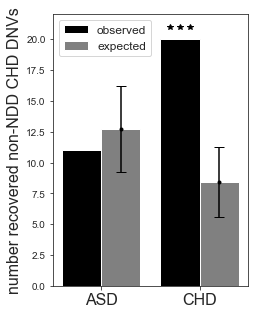

In [18]:
z_thresh = 2

# ---------------------------------------------------------------------------
# ----------- single ASD z-scores -----------

# filter by high ASD score
# update to filter by zprod<3 so we don't have any overlap with ASD-CHD intersecting set
z_ASD_g1 = z_ASD[(z_ASD>z_thresh)&(zprod<3)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC)) # don't include seeds

# filter by low CHD score too
z_ASD_g1 = list(np.intersect1d(z_ASD_g1,z_CHD[z_CHD<2].index.tolist()))


DNV_in_graph = list(np.intersect1d(DNV_noNDD_full,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,ASD_HC+CHD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC+CHD_HC)))

M = len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC+CHD_HC))
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(ASD_p))

# calculate expected mean and std given M,n,N
exp_ASD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_ASD_std = scipy.stats.hypergeom.std(M,n,N)


# ---------------------------------------------------------------------------
# ------------------- single CHD z-scores -------------------
z_CHD_g1 = z_CHD[(z_CHD>z_thresh)&(zprod<3)].index.tolist()

# filter by low ASD score as well
z_CHD_g1 = list(np.intersect1d(z_CHD_g1,z_ASD[z_ASD<2].index.tolist()))

z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC)) # don't include seeds

DNV_in_graph = list(np.intersect1d(DNV_noNDD_full,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,CHD_HC+ASD_HC))


CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC+ASD_HC)))

M = len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC+ASD_HC))
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(CHD_p))

# calculate expected mean and std given M,n,N
exp_CHD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_CHD_std = scipy.stats.hypergeom.std(M,n,N)
    
# -------------------------------------------
# plot the results
plt.figure(figsize=(3.5,5))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                

plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=16)
plt.ylabel('number recovered non-NDD CHD DNVs',fontsize=16)


# plt.savefig('../../manuscript/figures_1911/'+focal_interactome+'/z_score_num_recovered_DNVs_CHDonly_'+str(z_thresh)+'.png',
#            dpi=300,bbox_inches='tight')

(-1, 2.5)

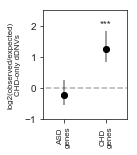

In [19]:

# ----------- plot the odds ratios -----------
plt.figure(figsize=(1.5,2))
recovered_list = [len(ASD_g1),len(CHD_g1)]
exp_list_mean = [exp_ASD_mean,exp_CHD_mean]
exp_list_std = [exp_ASD_std,exp_CHD_std]
obs_div_exp = np.divide(recovered_list,exp_list_mean)
lower_ebar=np.divide(recovered_list,np.add(exp_list_mean,exp_list_std))
upper_ebar=np.divide(recovered_list,np.subtract(exp_list_mean,exp_list_std))
pval_list = [ASD_p,CHD_p]

# plt.bar([0,1,2],obs_div_exp,width=.4,color='k',label='observed')
# plt.bar([0,1,2],obs_div_exp,color='k',width=.4)
log_obs_exp=np.log2(obs_div_exp)
log_yerr_lower=np.subtract(np.log2(obs_div_exp),np.log2(lower_ebar))
log_yerr_upper=np.subtract(np.log2(upper_ebar),np.log2(obs_div_exp))
plt.errorbar([0,1],log_obs_exp,yerr=[log_yerr_lower,
                                       log_yerr_upper],fmt='o',color='k',
            alpha=.5)
plt.plot([0,1],np.log2(obs_div_exp),'ko')
ax = plt.gca()
# ax.semilogy()
plt.ylabel('log2(observed/expected)\nCHD-only dDNVs',fontsize=8)
plt.xlim([-.5,1.5])
plt.xticks([0,1],['ASD\ngenes','CHD\ngenes'],fontsize=8,rotation='vertical')
plt.plot([-1,3],[0,0],'k--',alpha=.3)

# add stars for significance
for i in [0,1]:
    star_height = log_obs_exp[i]+log_yerr_upper[i]*1.25 # add 25% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        #plt.plot([i],[star_height],'k*')
        plt.annotate('*',(i,star_height),fontsize=10,ha='center')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        #plt.plot([i-.05,i+.05],[star_height]*2,'k*')
        plt.annotate('**',(i,star_height),fontsize=10,ha='center')
    elif (pval_list[i] <= 0.001):
        #plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        plt.annotate('***',(i,star_height),fontsize=10,ha='center')
        
plt.ylim([-1,2.5])
# plt.savefig('../../manuscript/figures_1911/Supplement/obs_div_exp_CHD_SPECIFIC_DNV.png',
#            dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/obs_div_exp_CHD_SPECIFIC_DNV.svg',
#            dpi=300,bbox_inches='tight')

# Make the same ASD-CHD density figure, but this time show the CHD-only NDDs

In [20]:

combine_after_zscore=True # whether to use the score combined before or after z-score calculation (this is obsolete.. should always be true now)
include_seeds=False # plot with or without seeds

z_ASD_abs = z_ASD.copy(deep=True)
ASD_HC_in_G = list(np.intersect1d(ASD_HC,Gint.nodes()))


z_CHD_abs = z_CHD.copy(deep=True)
CHD_HC_in_G = list(np.intersect1d(CHD_HC,Gint.nodes()))



if include_seeds==False: # remove seeds if false
    z_ASD_abs.loc[ASD_HC_in_G]=np.nan # remove the seeds
    z_CHD_abs.loc[CHD_HC_in_G]=np.nan # remove the seeds



-4.34949947011
-4.70643282787


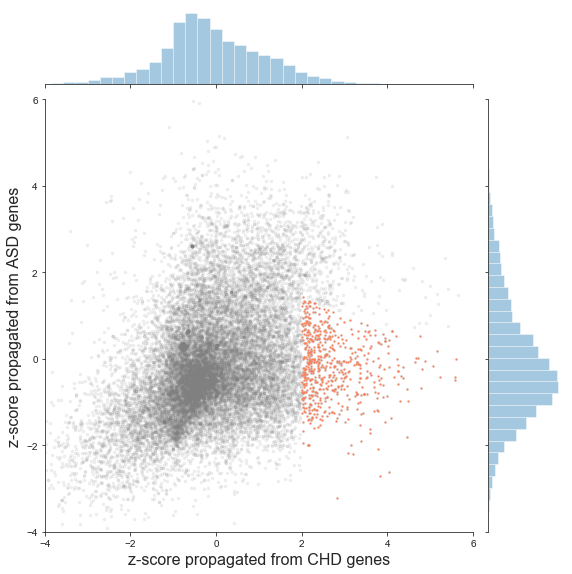

In [21]:

# -------------------- Plot on the paired disorder axes ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]
# j = sns.jointplot(z_CHD_abs,z_ASD_abs,gridsize=50,kind='hex',size=10)
j = sns.jointplot(z_CHD_abs,z_ASD_abs,kind='scatter',height=8,alpha=.1,joint_kws={'s':6,'color':'gray'})
plt.sca(j.ax_joint)

plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)

zthresh=3

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 

high_CHD_genes = z_CHD[(z_CHD>=2)&(zprod<3)].index.tolist()

# filter by low ASD score as well
high_CHD_genes = list(np.intersect1d(high_CHD_genes,z_ASD[z_ASD<2].index.tolist()))
    
# high_CHD_genes = z_CHD[z_CHD>zthresh].index.tolist()
# high_CHD_genes = list(np.intersect1d(high_CHD_genes,z_CHD[z_ASD<2.0].index.tolist()))
plt.plot((z_CHD_abs.loc[high_CHD_genes]),(z_ASD_abs.loc[high_CHD_genes]),'.',color='#F9825C',
         ms=2,alpha=1)

only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>=zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>=zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# overlay the DNVs with NDDs
# plt.plot(z_CHD_abs.loc[DNV_noNDD_full],z_ASD_abs.loc[DNV_noNDD_full],'k^',ms=3.5,alpha=.3)

#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_CHD_genes,DNV_noNDD_full)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()


#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_CHD_genes,DNV_noNDD_full)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()

# plot DNVs in relevant section bolder
# plt.plot(z_CHD_abs.loc[DNVs_top_10],z_ASD_abs.loc[DNVs_top_10],'k^',ms=5,alpha=.5)

# use adjustText to make labels not overlap     
# texts_tmp = [plt.text(z_CHD_abs.loc[d],z_ASD_abs.loc[d],
#                          d,fontsize=12) for d in DNVs_top_10]
# adjustText.adjust_text(texts_tmp,force_points=(0,0),force_objects=(0,0),expand_points=(0,0),expand_objects=(0,0),
#                       lim=3)


ax=plt.gca()

if include_seeds==False: # only set ades limits if not including seeds
    plt.xlim([-4,6])
    plt.ylim([-4,6])

fname_string = '../../manuscript/figures_1911/'+focal_interactome+'/ASD_CHD_zscore_noNDD'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.png'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.png'
    
# plt.savefig(fname_string,dpi=300,bbox_inches='tight')

# How do ASD-only genes rank?

36
583
929
19713
ASD enrichment = 0.04113619725263935
23
583
616
19712
CHD enrichment = 0.10413061364104761


Text(0,0.5,'number recovered ASD DNVs')

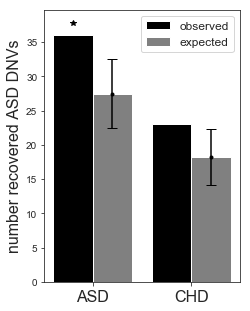

In [22]:
z_thresh = 2
# ---------------------------------------------------------------------------
# ------------------- single ASD z-scores -------------------
z_ASD_g1 = z_ASD[(z_ASD>=z_thresh)&(zprod<3)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC)) # don't include seeds

# filter by low CHD score too
z_ASD_g1 = list(np.intersect1d(z_ASD_g1,z_CHD[z_CHD<2].index.tolist()))


DNV_in_graph = list(np.intersect1d(SSC_DNV_genes,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,ASD_HC+CHD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC)))

M = len(np.setdiff1d(z_ASD.dropna().index.tolist(),ASD_HC))
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(ASD_p))

# calculate expected mean and std given M,n,N
exp_ASD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_ASD_std = scipy.stats.hypergeom.std(M,n,N)


# ---------------------------------------------------------------------------
# ------------------- single CHD z-scores -------------------
z_CHD_g1 = z_CHD[(z_CHD>=z_thresh)&(zprod<3)].index.tolist()

# filter by low ASD score as well
z_CHD_g1 = list(np.intersect1d(z_CHD_g1,z_ASD[z_ASD<2].index.tolist()))

z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC)) # don't include seeds

DNV_in_graph = list(np.intersect1d(SSC_DNV_genes,Gint.nodes()))
DNV_noseeds = list(np.setdiff1d(DNV_in_graph,CHD_HC+ASD_HC))


CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC)))

M = len(np.setdiff1d(z_CHD.dropna().index.tolist(),CHD_HC))
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(CHD_p))

# calculate expected mean and std given M,n,N
exp_CHD_mean = scipy.stats.hypergeom.mean(M,n,N)
exp_CHD_std = scipy.stats.hypergeom.std(M,n,N)
    
# -------------------------------------------
# plot the results
plt.figure(figsize=(3.5,5))

recovered_list = [len(ASD_g1),len(CHD_g1)]
pval_list = [ASD_p,CHD_p]

plt.bar([0,1],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4],[exp_ASD_mean,exp_CHD_mean],
             [exp_ASD_std,exp_CHD_std],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                


plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2],['ASD','CHD'],fontsize=16)
plt.ylabel('number recovered ASD DNVs',fontsize=16)


# plt.savefig('../../manuscript/figures_1911/'+focal_interactome+'/z_score_num_recovered_DNVs_ASDonly_'+str(z_thresh)+'.png',
#            dpi=300,bbox_inches='tight')

(-0.5, 1.0)

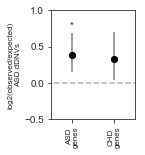

In [23]:

# ----------- plot the odds ratios -----------
plt.figure(figsize=(1.5,2))
recovered_list = [len(ASD_g1),len(CHD_g1)]
exp_list_mean = [exp_ASD_mean,exp_CHD_mean]
exp_list_std = [exp_ASD_std,exp_CHD_std]
obs_div_exp = np.divide(recovered_list,exp_list_mean)
lower_ebar=np.divide(recovered_list,np.add(exp_list_mean,exp_list_std))
upper_ebar=np.divide(recovered_list,np.subtract(exp_list_mean,exp_list_std))
pval_list = [ASD_p,CHD_p]

# plt.bar([0,1,2],obs_div_exp,width=.4,color='k',label='observed')
# plt.bar([0,1,2],obs_div_exp,color='k',width=.4)
log_obs_exp=np.log2(obs_div_exp)
log_yerr_lower=np.subtract(np.log2(obs_div_exp),np.log2(lower_ebar))
log_yerr_upper=np.subtract(np.log2(upper_ebar),np.log2(obs_div_exp))
plt.errorbar([0,1],log_obs_exp,yerr=[log_yerr_lower,
                                       log_yerr_upper],fmt='o',color='k',
            alpha=.5)
plt.plot([0,1],np.log2(obs_div_exp),'ko')
ax = plt.gca()
# ax.semilogy()
plt.ylabel('log2(observed/expected)\nASD dDNVs',fontsize=8)
plt.xlim([-.5,1.5])
plt.xticks([0,1],['ASD\ngenes','CHD\ngenes'],fontsize=8,rotation='vertical')
plt.plot([-1,3],[0,0],'k--',alpha=.3)

# add stars for significance
for i in [0,1]:
    star_height = log_obs_exp[i]+log_yerr_upper[i]*1.25 # add 25% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        #plt.plot([i],[star_height],'k*')
        plt.annotate('*',(i,star_height),fontsize=10,ha='center')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        #plt.plot([i-.05,i+.05],[star_height]*2,'k*')
        plt.annotate('**',(i,star_height),fontsize=10,ha='center')
    elif (pval_list[i] <= 0.001):
        #plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        plt.annotate('***',(i,star_height),fontsize=10,ha='center')
        
plt.ylim([-.5,1.0])
# plt.savefig('../../manuscript/figures_1911/Supplement/obs_div_exp_ASD_SPECIFIC_DNV.png',
#            dpi=300,bbox_inches='tight')
# plt.savefig('../../manuscript/figures_1911/Supplement/obs_div_exp_ASD_SPECIFIC_DNV.svg',
#            dpi=300,bbox_inches='tight')

-4.34949947011
-4.70643282787


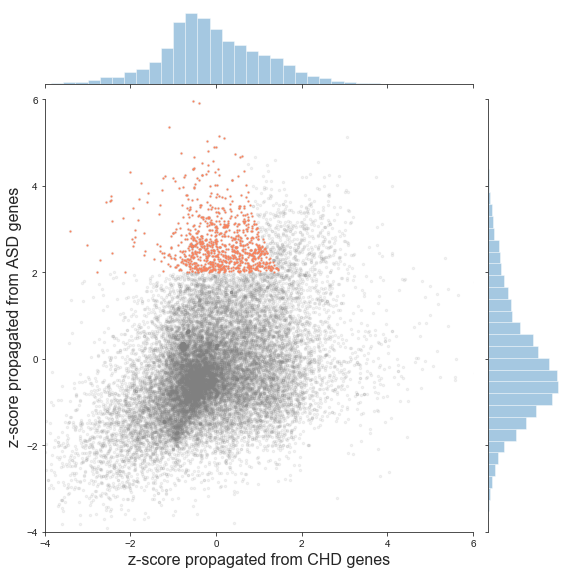

In [24]:


# -------------------- Plot on the paired disorder axes, ASD-specific ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]

j = sns.jointplot(z_CHD_abs,z_ASD_abs,kind='scatter',height=8,alpha=.1,joint_kws={'s':6,'color':'gray'})


plt.sca(j.ax_joint)

plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)


zthresh=3

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 
    
high_ASD_genes = z_ASD[(z_ASD>=2)&(zprod<3)].index.tolist()

# filter by low CHD score as well
high_ASD_genes = list(np.intersect1d(high_ASD_genes,z_CHD[z_CHD<2].index.tolist()))

# high_ASD_genes = z_ASD[z_ASD>zthresh].index.tolist()
# high_ASD_genes = list(np.intersect1d(high_ASD_genes,z_ASD[z_CHD<2.0].index.tolist()))
plt.plot((z_CHD_abs.loc[high_ASD_genes]),(z_ASD_abs.loc[high_ASD_genes]),'.',color='#F9825C',
         ms=2,alpha=1)

only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>=zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>=zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# plot the DNVs
# plt.plot(z_CHD_abs.loc[SSC_DNV_genes],z_ASD_abs.loc[SSC_DNV_genes],'k^',ms=3.5,alpha=.3)


#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = list(np.intersect1d(high_ASD_genes,SSC_DNV_genes)) #((z_ASD_abs.loc[DNV_noNDD_full]+10)*(z_CHD_abs.loc[DNV_noNDD_full]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
DNVs_top_10 = z_CHD_abs.loc[DNVs_top_10].dropna().index.tolist()
DNVs_top_10 = z_ASD_abs.loc[DNVs_top_10].dropna().sort_values(ascending=False).head(10).index.tolist()

# plot DNVs in relevant section bolder
# plt.plot(z_CHD_abs.loc[DNVs_top_10],z_ASD_abs.loc[DNVs_top_10],'k^',ms=5,alpha=.5)

# use adjustText to make labels not overlap     
# texts_tmp = [plt.text(z_CHD_abs.loc[d],z_ASD_abs.loc[d],
#                          d,fontsize=12) for d in DNVs_top_10]
# adjustText.adjust_text(texts_tmp,force_points=(0,0),force_objects=(0,0),expand_points=(0,0),expand_objects=(0,0),
#                       lim=3)
            
ax=plt.gca()

if include_seeds==False: # only set ades limits if not including seeds
    plt.xlim([-4,6])
    plt.ylim([-4,6])

#ax.set_yscale('log')
#ax.set_xscale('log')

fname_string = '../../manuscript/figures_1911/'+focal_interactome+'/ASD_CHD_zscore_ASD_focused'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.png'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.png'
    
# plt.savefig(fname_string,dpi=300,bbox_inches='tight')